# Analyse de données RNA-Seq issues de patients atteints de mélanome uvéal

### Introduction
Dans ce hackathon, nous tenterons de reproduire les résultats de [1].
Les données originales proviennent de [2], où les auteurs ont séquencé l’ARN d’échantillons de patients atteints de mélanome uvéal. Ces patients appartiennent à deux groupes:

1. patients mutés pour le gène SF3B1 (facteur d’épissage) et
2. patients non mutés pour ce gène. 

Dans [2], les auteurs n’ont pas trouvé de différences d’épissage entre les patients mutés et les non mutés (bien qu’il s’agisse d’un facteur d’épissage).
En revanche, les auteurs de [1] ont réanalysé les mêmes données, et ont trouvé les gènes suivants épissés différemment entre les deux conditions: 
* ABCC5, 
* CRNDE,
* UQCC,
* GUSBP11,
* ANKHD1,
* ADAM12.

### Données

Les données sont accessibles sur SRA
* Patients mutés 
  * [SRR628582](https://www.ncbi.nlm.nih.gov/sra/?term=SRR628582)
  * [SRR628583](https://www.ncbi.nlm.nih.gov/sra/?term=SRR628583)
  * [SRR628584](https://www.ncbi.nlm.nih.gov/sra/?term=SRR628584)
* Patients non mutés
  * [SRR628585](https://www.ncbi.nlm.nih.gov/sra/?term=SRR628585)
  * [SRR628586](https://www.ncbi.nlm.nih.gov/sra/?term=SRR628586)
  * [SRR628587](https://www.ncbi.nlm.nih.gov/sra/?term=SRR628587)
  * [SRR628588](https://www.ncbi.nlm.nih.gov/sra/?term=SRR628588)
  * [SRR628589](https://www.ncbi.nlm.nih.gov/sra/?term=SRR628589)

### Objectif

Nous tenterons de retrouver les gènes différentiellement épissés entre les deux conditions, en utilisant un système de workflow et les outils suivants:
* [STAR](https://github.com/alexdobin/STAR),
* [DEXSeq](http://bioconductor.org/packages/release/bioc/html/DEXSeq.html),
* [SRA toolkit](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=software)
* [R](https://cran.r-project.org/)
* [Samtools](http://www.htslib.org/download/)

Le workflow peut se présenter comme cela:

![RNA Workflow](hackathon_1_workflow.svg)

## Références
* [1] [Furney et al. (2013)](https://www.ncbi.nlm.nih.gov/pubmed/23861464)
* [2] [Harbour et al. (2013)](https://www.ncbi.nlm.nih.gov/pubmed/23313955)

### Configuration de l'environnement IPython

In [2]:
import os
import subprocess
import urllib.request
%load_ext rpy2.ipython

Initialisation de la parallélisation. Il faut auparavant démarrer ipcluster, par exemple via l'onglet "IPython clusters" de l'[accueil du notebook](/tree).

In [2]:
from ipyparallel import Client, require
rc = Client()
par = rc.load_balanced_view()

# Génome

Téléchargement des chromosomes et indexation avec STAR.

In [ ]:
chrs = ["chr%d" % i for i in range(1,23)] + ["chr%s" % n for n in ["M","X","Y"]]

In [ ]:
if not os.path.exists("chrs"):
    os.makedirs("chrs")
for c in chrs:
    chrfile = "chrs/%s.fa.gz" % c
    if not os.path.exists(chrfile):
        urlretrieve("http://hgdownload.soe.ucsc.edu/goldenPath/hg19/chromosomes/%s.fa.gz" % c, chrfile)
    print("%s ready" % c)

In [10]:
gendir = "ref"
if not os.path.exists(gendir):
    os.makedirs(gendir)
!gunzip -c chrs/chr*.fa.gz>ref.fa
%time os.system("STAR --runThreadN 10 --runMode genomeGenerate --genomeDir %s --genomeFastaFiles ref.fa" % (gendir))
os.unlink("ref.fa")
print("Genome index ready in '%s'" % gendir)

CPU times: user 7.8 ms, sys: 5.42 ms, total: 13.2 ms
Wall time: 1min 24s
Genome index ready in 'ref'


# Pré-traitement des données SRA

Les données de RNA-seq sont téléchargées et converties au format fastq, avant d'être alignées sur le génome.

In [3]:
SRAIDS_MUTES = ["SRR628582", "SRR628583", "SRR628584"]
SRAIDS_WT = ["SRR628585", "SRR628586", "SRR628587", "SRR628588", "SRR628589"]
SRAIDS = SRAIDS_MUTES + SRAIDS_WT
rc[:]["SRAIDS_WT"] = SRAIDS_WT

### Fetch files and convert to FASTQ

In [ ]:
# download SRA files
for sraid in SRAIDS:
    subprocess.check_call(["prefetch", sraid])
    print("%s.sra fetched" % sraid)

# convert to fastq
@require("os")
def sra2fastq(sraid):
    os.system("fastq-dump --gzip --split-files %s" % sraid)
    os.unlink(os.path.expanduser("~/ncbi/public/sra/%s.sra" % sraid))
    print("%s ready" % sraid)
    return sraid

%time par.map_sync(sra2fastq, SRAIDS)

### Alignement

Alignement des reads de chaque fichier FASTQ avec le génome. Cela génère un fichier `bam` par fichier FASTQ.

In [6]:
staropts = " ".join(["--outSAMstrandField intronMotif",
     "--outFilterMismatchNmax 4",
     "--outFilterMultimapNmax 10",
     "--genomeDir %s" % "ref",
     "--readFilesIn {0}_1.fastq.gz {0}_2.fastq.gz",
    "--readFilesCommand zcat",
     "--runThreadN 10"
     "--outSAMunmapped None",
     "--outSAMtype BAM SortedByCoordinate",
     "--outStd BAM_SortedByCoordinate",
     "--genomeLoad NoSharedMemory",
     "--limitBAMsortRAM 3000000000"])

def align_sra(sraid):
    os.system("STAR %s > %s.bam" % (staropts.format(sraid), sraid))
    #urllib.request.urlretrieve("http://appliances.france-bioinformatique.fr/reprohackathon/%s.bam" % sraid, "%s.bam"%sraid)
    print("%s.bam ready" % sraid)

for sraid in SRAIDS:
    align_sra(sraid)

SRR628582.bam ready
SRR628583.bam ready
SRR628584.bam ready
SRR628585.bam ready
SRR628586.bam ready
SRR628587.bam ready
SRR628588.bam ready
SRR628589.bam ready


Indexation des fichiers bam avec [samtools](https://github.com/samtools/samtools).

In [7]:
@require("subprocess")
def index_bam(sraid):
    return subprocess.check_call(["samtools", "index", "%s.bam"%sraid])

%time par.map_sync(index_bam, SRAIDS)

CPU times: user 13.2 ms, sys: 13.3 ms, total: 26.4 ms
Wall time: 1min 59s


[0, 0, 0, 0, 0, 0, 0, 0]

###  Annotations

Préparation des annotations des gènes, et conversion au format DEXSeq.

In [8]:
!gunzip -c "data/refgene_hg19.gtf.gz" > gtf
!gunzip -c "data/refgene_hg19.table.gz" > table
!perl addGeneNameToUcscGFF.pl gtf table > ann.gtf
!rm -f gtf table
!/opt/conda/envs/python2/bin/python /opt/conda/lib/R/library/DEXSeq/python_scripts/dexseq_prepare_annotation.py ann.gtf annotations_DEXSeq.gtf

## Analyse

### Comptage

Comptage du nombre de reads

In [ ]:
@require("os")
def count(sraid):
    python2 = "/opt/conda/envs/python2/bin/python"
    script = "/opt/conda/lib/R/library/DEXSeq/python_scripts/dexseq_count.py"
    os.system("{python2} {script} -p yes -r pos -s no -f bam annotations_DEXSeq.gtf {sraid}.bam count{sraid}.txt".format(python2=python2, script=script, sraid=sraid))
    condition = "WT" if sraid in SRAIDS_WT else "MUTED"
    os.system("grep -v '^_' count{sraid}.txt | awk '{{ print \"{condition}\\t{sraid}\\t\" $0 }}' > mapcount{sraid}.txt".format(sraid=sraid, condition=condition))
    print("%s counted" % sraid)
    
%time  par.map_sync(count, SRAIDS)
!cat mapcount*.txt > mapcounts

CPU times: user 70.7 ms, sys: 37.5 ms, total: 108 ms
Wall time: 46min 24s


Rassemblement des comptages:

In [4]:
%%R
library(DEXSeq)
library(reshape2)
options(bitmapType='cairo')

## Count data
counts<-read.table("mapcounts")
colnames(counts)=c("cond","sraid","exon","count")
widecount=dcast(counts, exon ~ sraid,value.var="count")
row.names(widecount)=widecount$exon
widecount=widecount[,-1]
## Exon and Gene Names
exons=sapply(strsplit(row.names(widecount), ":"),"[",2)
genes=sapply(strsplit(row.names(widecount), ":"),"[",1)

## Sample Annotation
samples=unique(counts[,c(1,2)])$cond
sampleTable <- data.frame(lapply(unique(counts[,c(1,2)]), as.character),libType="paired-end",stringsAsFactors=FALSE)
row.names(sampleTable)=sampleTable$sraid
sampleTable=sampleTable[,-2]
colnames(sampleTable)=c("condition","libType")
# on remet dans l'ordre
sampleTable=sampleTable[colnames(widecount),]

# Write into individual files
countfiles=paste0(colnames(widecount),".txt")
for(sample in colnames(widecount)){
    write.table(file=paste0(sample,".txt"),data.frame(row.names=row.names(widecount),count=widecount[,sample]),row.names=TRUE,col.names=FALSE,quote=FALSE,sep="\t")
}

/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocParallel

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Biobase

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clust

In [5]:
# Create DEXSeqDataSet
%R dxd=DEXSeqDataSetFromHTSeq(countfiles,sampleData=sampleTable,design=~sample+exon+condition:exon,flattenedfile="annotations_DEXSeq.gtf")

/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)


R object with classes: ('DEXSeqDataSet',) mapped to:
<RS4 - Python:0x7f0f0d108308 / R:0x2b669fc8>

### Analyse statique

In [7]:
%R dxd=estimateSizeFactors(dxd)
%R dxd=estimateDispersions(dxd)

/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: using supplied model matrix

  warnings.warn(x, RRuntimeWarning)


R object with classes: ('DEXSeqDataSet',) mapped to:
<RS4 - Python:0x7f0f0d108188 / R:0x36eeb098>

### Graphiques

/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Fit for gene/exon chr1_MACF1+ threw the next warning(s): the matrix is either rank-deficient or indefinite

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Fit for gene/exon chr12_ITPR2- threw the next warning(s): the matrix is either rank-deficient or indefinite

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Fit for gene/exon chr16_ITGAL+ threw the next warning(s): the matrix is either rank-deficient or indefinite

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Fit for gene/exon chr16_NLRC5+ threw the next warning(s): the matrix is either rank-deficient or indefinite

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.p

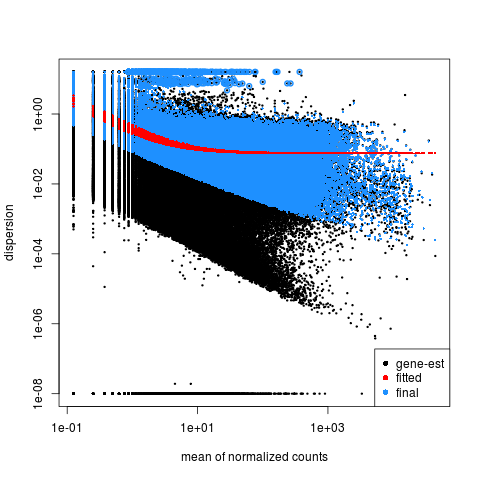

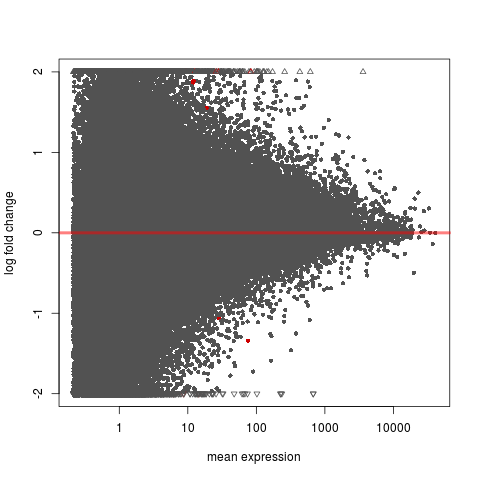

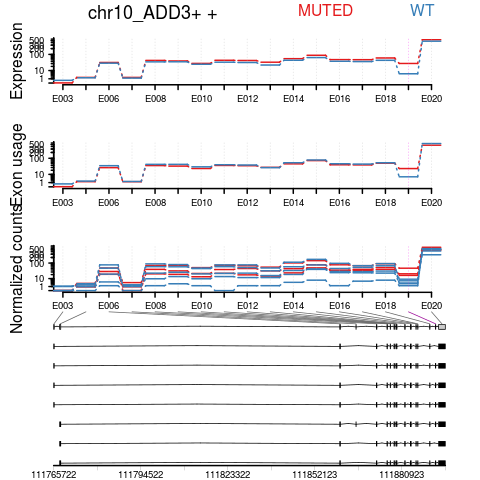

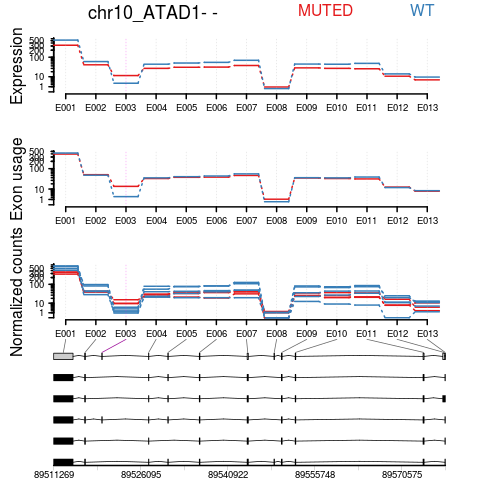

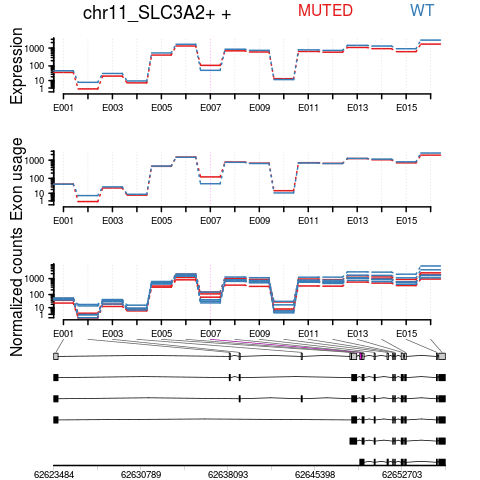

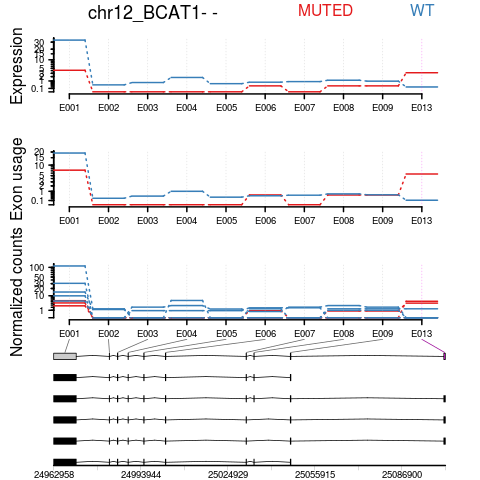

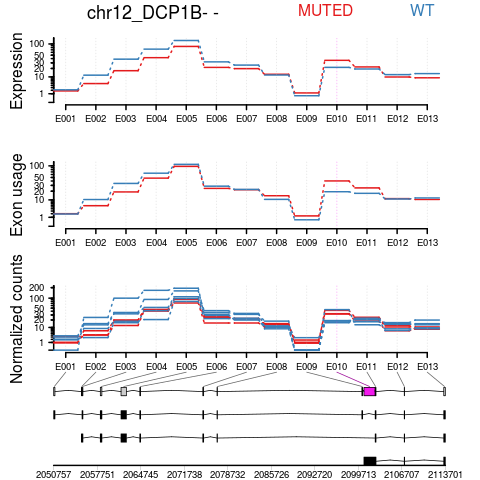

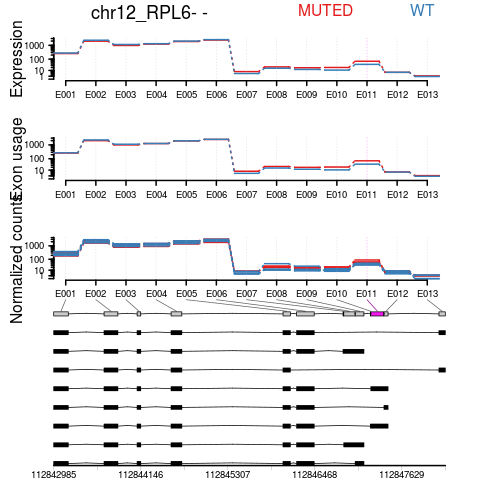

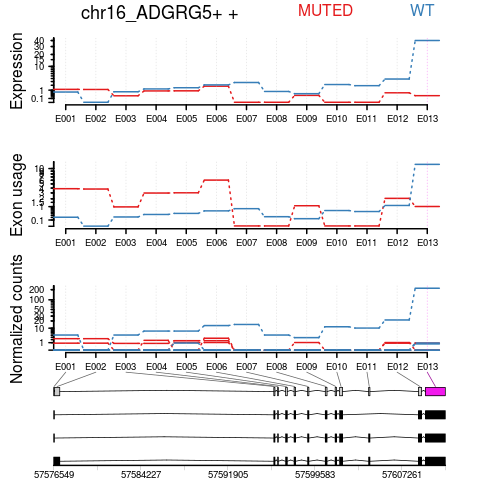

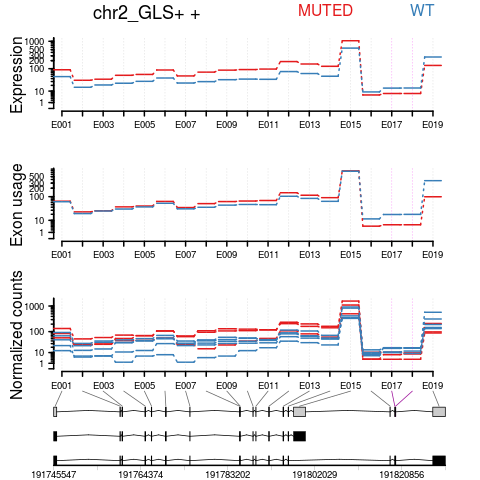

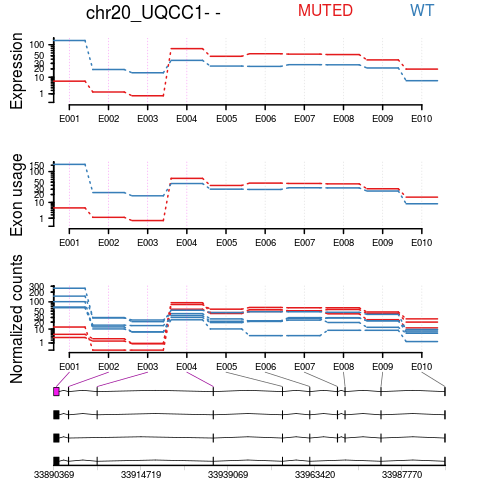

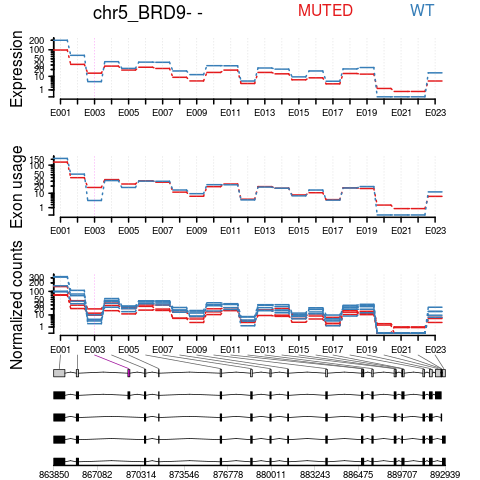

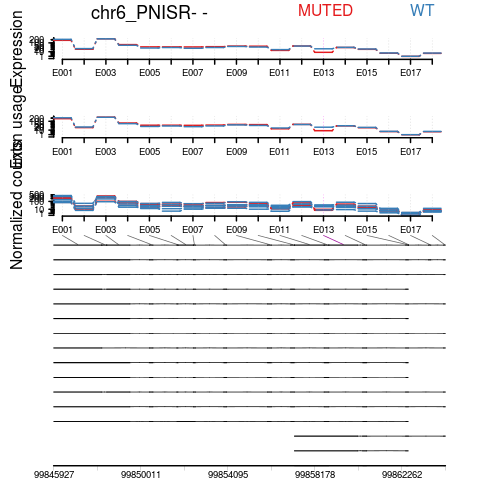

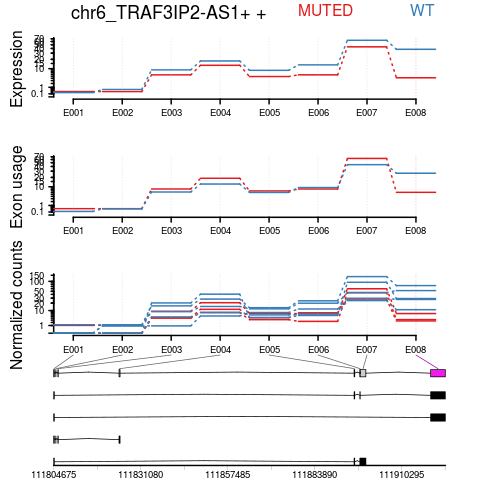

In [8]:
%%R
plotDispEsts(dxd)

dxd=testForDEU(dxd)
dxd=estimateExonFoldChanges(dxd,fitExpToVar="condition")
dxr1=DEXSeqResults(dxd)
dxr1=na.omit(dxr1)
#table(dxr1$pvalue<0.1)
#write.table(file="diff_exons_out.txt",dxr1[dxr1$padj<0.1,])
#table(tapply(dxr1$padj<0.1,dxr1$groupID,any))

plotMA(dxr1,cex=0.8)

for(i in unique(dxr1[dxr1$padj<0.1,"groupID"])){
      plotDEXSeq( dxr1,i,legend=TRUE,cex.axis=1.2,cex=1.3,lwd=2,norCounts=TRUE,splicing=TRUE,displayTranscripts=TRUE)
}